In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '../Config')
from lablib import *

## TODO

- risolvere la funzione che va sopra 1
- risolvere le fasi di RL fottute
- riconsiderare gli errori

## Funzioni di trasferimento

In [8]:
pi = np.pi

def RC_R():
    def mod(W, R, C):
        return R/(np.sqrt(R**2 + 1/(W*C)**2))
    def fase(W, R, C):
        return np.arctan(1/(W*C*R))
    return mod, fase

def RC_C():
    def mod(W, R, C):
        return 1/(np.sqrt(1+(R*C*W)**2))
    def fase(W, R, C):
        return np.arctan(R*C*W)
    return mod, fase

def RL_R():
    def mod(W, R, L):
        return R/(np.sqrt(R**2 + (W*L)**2))
    def fase(W, R, L):
        return np.arctan(W*L/R)
    return mod, fase

def RL_L():
    def mod(W, R, L):
        return W*L/(np.sqrt(R**2 + (W*L)**2))
    def fase(W, R, L):
        return np.arctan(W*L/R) - pi/2
    return mod, fase

def RLC_R():
    def mod(W, R, L, C):
        return R/(np.sqrt(R**2 + (W*L - 1/(W*C))**2))
    def fase(W, R, L, C):
        return np.arctan(((W**2)*L*C - 1)/(W*C*R))
    return mod, fase

def RLC_C():
    def mod(W, R, L, C):
        return 1/(np.sqrt((1 - (W**2)*L*C)**2 + (W*C*R)**2))
    def fase(W, R, L, C):
        return np.arctan(W*C*R/(1 - (W**2)*L*C))
    return mod, fase


def RLC_L():
    def mod(W, R, L, C):
        return W*L/(np.sqrt((1 - (W**2)*L*C)**2 + (W*C*R)**2))
    def fase(W, R, L, C):
        return np.arctan((1 - (W**2)*L*C)/(W*C*R))
    return mod, fase

def RLC_LC():
    def mod(W, R, L, C):
        return abs((1-(W**2)*L*C)/(np.sqrt((1-(W**2)*L*C)**2 + (R*W*C)**2)))
    def fase (W, R, L, C):
        return np.arctan((R*W*C)/(1-(W**2)*L*C))
    return mod, fase

# Prima parte RC RL 

## CIRCUITO RC
 Capacità utilizzata= $99 \pm 1$ nF \
 Resistenza= $100\pm 1 \Omega$ (check)
 
 Incertezza fase (CH2-CH1) = $\pm 1$ \
 Incertezza Ampiezza V_in(CH1) = $\pm 0.05$   Trasportarla su asse x e asse y \
 Incertezza Ampiezza V_out (CH2) = $\pm 0.05$ \
 Incertezza differenza (MATH)  = $\pm 0.01$ \

 le fasi nel foglio sono scritte in gradi \ 

 Per il voltaggio a capo di Z bisogna sottrarre a mano V_a e V_b

 **R E C SONO SBAGLIATE**

In [9]:
dati1 = pd.read_excel("dati_rc.xlsx")
RC_freq, RC_amp_A, RC_amp_B, RC_amp_AB, RC_fase_A, RC_fase_AB = dati1.iloc[:, 0:6].values.T
# .T serve a trasporre la matrice, ovvero a scambiare righe e colonne

### Resistenza

#### Modulo

<>:14: SyntaxWarning: invalid escape sequence '\o'
<>:14: SyntaxWarning: invalid escape sequence '\o'
C:\Users\franc\AppData\Local\Temp\ipykernel_16880\3782010373.py:14: SyntaxWarning: invalid escape sequence '\o'
  plt.title("$H_R$ vs $\omega$")


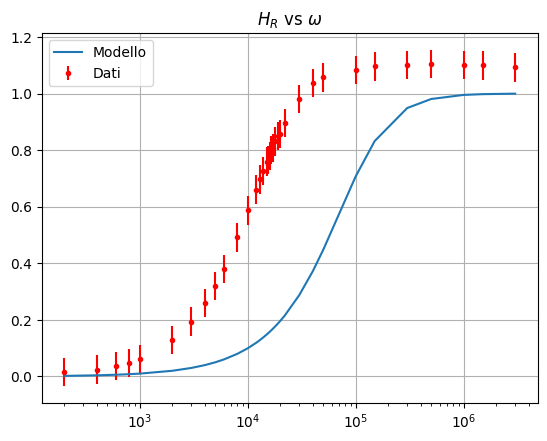

In [10]:
# PLot dati RC_R resistenza
RC_H_R = [i/j for i,j in zip(RC_amp_B, RC_amp_A)]
#RC_R_err = [0.01]*len(RC_H_R)
RC_R_err = np.sqrt((0.05/RC_amp_A)**2+(RC_amp_B*0.05/(RC_amp_A)**2)**2)
RC_vel_ang = RC_freq*2*pi

rc_r_mod, rc_r_fase = RC_R()
x = np.linspace(min(RC_vel_ang), max(RC_vel_ang), 10000)
Res_RC = 100 #ohm
Res_RC_err = 1
Cap_RC = 99e-9 #farad
Cap_RC_err = 1e-9

plt.errorbar(RC_vel_ang, RC_H_R, RC_R_err, fmt = '.r', label = "Dati")
plt.plot(x, rc_r_mod(x, Res_RC, Cap_RC), label = "Modello")
plt.xscale('log')
plt.title("$H_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

# il mio amico piu' esperto di noi dice che potrebbe essersi formato un
# trasformatore (correnti induttive) che fotte i dati 

In [ ]:
# fit dati resistenza e test compatibilità

pars1, vals1, ers1, *other1 = LS_fit(RC_vel_ang, RC_H_R, RC_R_err, rc_r_mod, R = Res_RC, C = Cap_RC)

t_RC_R_mod_R = TestCompatibilita(Res_RC, Res_RC_err, vals1[0], ers1[0])
t_RC_R_mod_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals1[1], ers1[1])

for res, val, err in zip(pars1, vals1, ers1):
    print(f"{res} = {val:.4g} +- {err:.4g}")

print(f"Distanza in deviazioni standard per R: {t_RC_R_mod_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_R_mod_C:.2g}")

In [ ]:
#Plot da inserire nella relazione: circuito RC, MODULO del trasferimento per R

plt.errorbar(RC_vel_ang, RC_H_R, RC_R_err, fmt = '.r', label = "Dati")
plt.plot(x, rc_r_mod(x, vals1[0], vals1[1]), label = "Fit effettuato")
plt.xlabel("Frequenza [Hz]")
plt.ylabel("$V_{out}/V_{in}$")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

In [11]:
# fit dati resistenza (con fattore correttivo)

def RC_R_just():
    def mod(W, R, C, a):
        return a*R/(np.sqrt(R**2 + 1/(W*C)**2))
    def fase(W, R, C):
        return np.arctan(1/(W*C*R))
    return mod, fase

rc_r_mod_just, rc_r_fase_just = RC_R_just()

pars1_5, vals1_5, ers1_5, *other1_5 = LS_fit(RC_vel_ang, RC_H_R, RC_R_err, rc_r_mod_just, R = Res_RC, C = Cap_RC, a = 1) # separare le funzioni sopra

t_RC_R_mod_just_R = TestCompatibilita(Res_RC, Res_RC_err, vals1_5[0], ers1_5[0])
t_RC_R_mod_just_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals1_5[1], ers1_5[1])

for i, j, k in zip(pars1_5, vals1_5, ers1_5):
    print(f"{i} = {j:.4g} +- {k:.4g}")

print(f"Distanza in deviazioni standard per R: {t_RC_R_mod_just_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_R_mod_just_C:.2g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 39.21 (χ²/ndof = 1.2)      │              Nfcn = 52               │
│ EDM = 2.2e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │   0.3e3   │   0.9e3   │            │            │         │         │       │
│ 1 │ C    │  0.3e-6   │  0.9e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬─────────────────────────────────┐
│   │               R               C │
├───┼─────────────────────────────────┤
│ R │        7.96e+05 -795.6478548e-6 │
│ C │ -795.6478548e-6        7.96e-13 │
└───┴─────────────────────────────────┘

In [ ]:
# PLot dati RC_R con fattore correttivo da inserire nella relazione

A = vals1_5[2] #fattore correttivo

plt.errorbar(RC_vel_ang, RC_H_R, RC_R_err, fmt = '.r', label = "Dati")
plt.plot(RC_vel_ang, rc_r_mod_just(RC_vel_ang, vals1_5[0], vals1_5[1], a = A), label = "Fit effettuato")
plt.xlabel("Frequenza [Hz]")
plt.ylabel("$V_{out}/V_{in}$")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

#### Fase

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
C:\Users\franc\AppData\Local\Temp\ipykernel_16880\807058087.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\phi_R$ vs $\omega$")


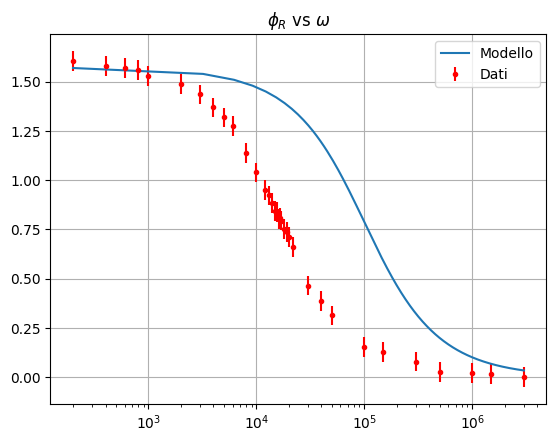

In [12]:
#plot resistenza fase
RC_F_err = [np.deg2rad(2)]*len(RC_fase_A)

plt.errorbar(RC_vel_ang, [np.deg2rad(i) for i in RC_fase_A], RC_F_err, fmt='.r', label='Dati')
plt.plot(x, rc_r_fase(x, Res_RC, Cap_RC), label='Modello')
plt.xscale('log')
plt.title("$\phi_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

In [13]:
# fit resistenza fase

pars2, vals2, ers2, *other2 = LS_fit(RC_vel_ang, [np.deg2rad(i) for i in RC_fase_A], 
                                     RC_F_err, rc_r_fase, R = Res_RC, C = Cap_RC)

t_RC_R_fase_R = TestCompatibilita(Res_RC, Res_RC_err, vals2[0], ers2[0])
t_RC_R_fase_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals2[1], ers2[1])

for i, j, k in zip(pars2, vals2, ers2):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Distanza in deviazioni standard per R: {t_RC_R_fase_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_R_fase_C:.2g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.73 (χ²/ndof = 0.4)      │              Nfcn = 46               │
│ EDM = 7.99e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │   0.2e3   │   0.4e3   │            │            │         │         │       │
│ 1 │ C    │  0.2e-6   │  0.4e-6   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────────┐
│   │                R                C │
├───┼───────────────────────────────────┤
│ R │         1.62e+05 -162.41495103e-6 │
│ C │ -162.41495103e-6         1.62e-13 │
└───┴───────────────────────────────────┘

In [ ]:
#Plot da inserire nella relazione: circuito RC, FASE del trasferimento per R

plt.errorbar(RC_vel_ang, [np.deg2rad(i) for i in RC_fase_A], RC_F_err, fmt='.r', label='Dati')
plt.plot(x, rc_r_fase(x, vals2[0], vals2[1]), label='Fit effettuato')
plt.xlabel("Frequenza [Hz]")
plt.ylabel("$\phi$ [rad]")
plt.xscale('log')
plt.grid()
plt.legend()
plt.show()

### Capacità

#### Modulo

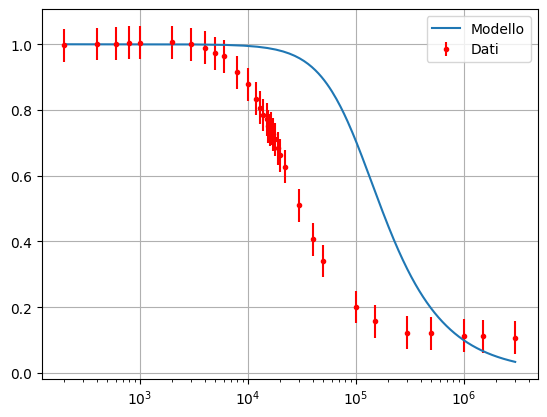

In [14]:
#plot dati RC capacità

RC_H_C = [i/j for i,j in zip(RC_amp_AB, RC_amp_A)]
RC_C_err = [.02]*len(RC_H_C)
rc_c_mod, rc_c_fase = RC_C()

plt.errorbar(RC_vel_ang, RC_H_C, RC_C_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_mod(x, Res_RC, Cap_RC), label='Modello')
plt.xscale('log')
plt.title("$H_C$ vs $\omega$")
plt.legend()
plt.grid()
plt.show()

**Da notare che per alte frequenze non corrisponde piu'** \
Stesso comportamento di quanto verificato per la resistenza sopra. \
Questo fa pensare ad un errore comune

In [15]:
# fit RC capacità

pars3, vals3, ers3, *other3 = LS_fit(RC_vel_ang, RC_H_C, RC_C_err, rc_c_mod, R = Res_RC, C = Cap_RC)

t_RC_C_mod_R = TestCompatibilita(Res_RC, Res_RC_err, vals3[0], ers3[0])
t_RC_C_mod_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals3[1], ers3[1])

for i, j, k in zip(pars3, vals3, ers3):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Distanza in deviazioni standard per R: {t_RC_C_mod_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_C_mod_C:.2g}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 17.16 (χ²/ndof = 0.5)      │              Nfcn = 42               │
│ EDM = 2.82e-09 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │     Covariance FORCED pos. def.      │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ R    │  0.23e3   │  0.14e3   │            │            │         │         │       │
│ 1 │ C    │  0.23e-6  │  0.14e-6  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────────────────────┐
│   │                R                C │
├───┼───────────────────────────────────┤
│ R │         1.96e+04 -19.558056918e-6 │
│ C │ -19.558056918e-6         1.96e-14 │
└───┴───────────────────────────────────┘

In [ ]:
#Plot da inserire nella relazione: circuito RC, MODULO del trasferimento per C

RC_H_C = [i/j for i,j in zip(RC_amp_AB, RC_amp_A)]
RC_C_err = [.02]*len(RC_H_C)
rc_c_mod, rc_c_fase = RC_C()

plt.errorbar(RC_vel_ang, RC_H_C, RC_C_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_mod(x, vals3[0], vals3[1]), label='Fit effettuato')
plt.xlabel("Frequenza [Hz]")
plt.ylabel("$V_{out}/V_{in}$")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# fit RC capacità con fattori correttivi

def RC_C_just():
    def mod(W, R, C, a, b):
        return a/(np.sqrt(1+(R*C*W)**2)) + b
    def fase(W, R, C, a, b):
        return a*np.arctan(R*C*W) + b
    return mod, fase

rc_c_mod_just, rc_c_fase_just = RC_C_just()

pars3_5, vals3_5, ers3_5, *other3_5 = LS_fit(RC_vel_ang, RC_H_C, RC_C_err, rc_c_mod_just, R = Res_RC, C = Cap_RC, a = 1, b = 0)

t_RC_C_mod_just_R = TestCompatibilita(Res_RC, Res_RC_err, vals3_5[0], ers3_5[0])
t_RC_C_mod_just_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals3_5[1], ers3_5[1])

for i, j, k in zip(pars3_5, vals3_5, ers3_5):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Distanza in deviazioni standard per R: {t_RC_C_mod_just_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_C_mod_just_C:.2g}")

In [ ]:
# plot RC capacità con fattori correttivi

plt.errorbar(RC_vel_ang, RC_H_C, RC_C_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_mod_just(x, Res_RC, Cap_RC, a = vals3_5[2], b = vals3_5[3]), label='Modello')
plt.xscale('log')
plt.title("$H_C$ vs $\omega$ (con fattori correttivi)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# PLot dati RC_C con fattore correttivo da inserire nella relazione

plt.errorbar(RC_vel_ang, RC_H_C, RC_C_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_mod_just(x, vals3_5[0], vals3_5[1], a = vals3_5[2], b = vals3_5[3]), label='Fit effettuato')
plt.xlabel("Frequenza [Hz]")
plt.ylabel("$V_{out}/V_{in}$")
plt.xscale('log')
plt.legend()
plt.grid()
plt.show()

#### Fase

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:6: SyntaxWarning: invalid escape sequence '\p'
C:\Users\franc\AppData\Local\Temp\ipykernel_16880\3946124598.py:6: SyntaxWarning: invalid escape sequence '\p'
  plt.title("$\phi_C$ vs $\omega$")


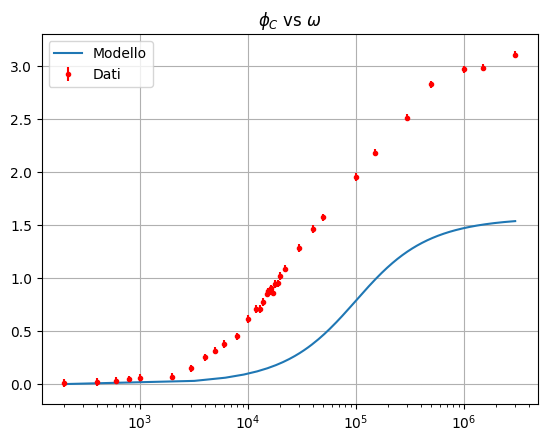

In [16]:
#plot RC capacità fase

plt.errorbar(RC_vel_ang, [np.deg2rad(i) for i in RC_fase_AB], RC_F_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_fase(x, Res_RC, Cap_RC), label='Modello')
plt.xscale('log')
plt.title("$\phi_C$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()


In [ ]:
#tentativo correzione RC capacità fase

# RC_fase_AB_just = RC_fase_AB/2

# plt.errorbar(RC_vel_ang, [np.deg2rad(i) for i in RC_fase_AB_just], RC_F_err, fmt='.r', label='Dati')      #se divido per due riscalo tutti i dati
# plt.plot(x, rc_c_fase(x, Res_RC, Cap_RC), label='Modello')
# plt.xscale('log')
# plt.title("$\phi_C$ vs $\omega$  (con fattore correttivo)")
# plt.grid()
# plt.legend()
# plt.show()

In [ ]:
# Tentativo di fit capacita fase 
# (correzione: ho aggiunto la divisione per due in np.def2rad(i))


# pars4, vals4, ers4, *other4 = LS_fit(RC_vel_ang, [np.deg2rad(i)/2 for i in RC_fase_AB], 
#                                      RC_F_err, rc_c_fase, R = Res_RC, C = Cap_RC)

In [ ]:
# Tentativo di fit capacita fase con fattori correttivi

pars4_5, vals4_5, ers4_5, *other4_5 = LS_fit(RC_vel_ang, [np.deg2rad(i)/2 for i in RC_fase_AB], RC_F_err, 
                                             rc_c_fase_just, R = Res_RC, C = Cap_RC, a = 1, b = 0)

t_RC_C_fase_R = TestCompatibilita(Res_RC, Res_RC_err, vals4_5[0], ers4_5[0])
t_RC_C_fase_C = TestCompatibilita(Cap_RC, Cap_RC_err, vals4_5[1], ers4_5[1])

for i, j, k in zip(pars4_5, vals4_5, ers4_5):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Distanza in deviazioni standard per R: {t_RC_C_fase_R:.2g}")
print(f"Distanza in deviazioni standard per C: {t_RC_C_fase_C:.2g}")

In [ ]:
# plot RC capacità fase con fattori correttivi

plt.errorbar(RC_vel_ang, [np.deg2rad(i)/2 for i in RC_fase_AB], RC_F_err, fmt='.r', label='Dati')
plt.plot(x, rc_c_fase_just(x, Res_RC, Cap_RC, a = vals4_5[2], b = vals4_5[3]), label='Modello')
plt.xscale('log')
plt.title("$\phi_C$ vs $\omega$ (con fattori correttivi)")
plt.grid()
plt.legend()
plt.show()

Anche con i fattori correttivi non esce particolarmente bene \
Potrebbe essere un modello piu' complesso, non stiamo considerando qualcosa oppure abbiamo sbagliato i dati

## CIRCUITO RL


Induttanza utilizzata $\approx 0.050$ H\
Resistenza utilizzata = $1000 \Omega$ \
Resistenza parassita L = $39.4 \pm0.1 \Omega$ \
Incertezza fase =  1 deg \
Incertezza ampiezza V_in = 0.01 \ 
Incertezza ampiezza V_out =  0.01\
Incertezza differenza (MATH) =  0.001 

Frequenza range $500 -  $ Hz

In [ ]:
dati2 = pd.read_excel("dati_rl.xlsx")
RL_freq, RL_amp_A, RL_amp_B, RL_amp_ab, RL_fase_A, RL_fase_AB = dati2.iloc[:, 0:6].values.T

### Resistenza

#### Modulo

In [ ]:
RL_H_R = [i/j for i,j in zip(RL_amp_B, RL_amp_A)]
RL_R_err = [0.02]*len(RL_H_R)
RL_vel_ang = RL_freq * 2 * pi 

rl_r_mod, rl_r_fase = RL_R()
x2 = np.linspace(min(RL_vel_ang), max(RL_vel_ang), 10000)
Res_RL = 1040 # ohm, considerando quella parassita
Ind = 0.05 # H

plt.errorbar(RL_vel_ang, RL_H_R, RL_R_err, fmt = '.r', label = "Dati")
plt.plot(RL_vel_ang, rl_r_mod(RL_vel_ang, Res_RL, Ind), label = "Modello")
plt.xscale('log')
plt.title("$H_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

Possiamo provare a eliminare alcuni dati dal centro per non influire sulla qualita' del fit altrove

In [ ]:
# fit dati resistenza

init = 0 # il primo valore da cui fittare
pars5, vals5, ers5, *other5 = LS_fit(RL_vel_ang[init:], RL_H_R[init:], RL_R_err[init:], rl_r_mod, R = Res_RL, L = Ind) 

t_RL_R_mod_R = TestCompatibilita(Res_RC, Res_RC_err, vals5[0], ers5[0])
t_RL_R_mod_L = TestCompatibilita(Cap_RC, Cap_RC_err, vals5[1], ers5[1])


print("p-value = ", other5[0])

for i, j, k in zip(pars5, vals5, ers5):
    print(f"{i} = {j:.4g} +- {k:.4g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RL/vals5[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals5[1]:.4g}")

print(f"Distanza in deviazioni standard per R: {t_RL_R_mod_R:.2g}")
print(f"Distanza in deviazioni standard per L: {t_RL_R_mod_L:.2g}")


#### Fase

In [ ]:
# plot resistenza fase

plt.errorbar(RL_vel_ang, [np.deg2rad(i) for i in RL_fase_A], RL_R_err, fmt='.r', label='Dati')
plt.plot(x2, rl_r_fase(x2, Res_RL, Ind), label='Modello')
plt.xscale('log')
plt.title("$\phi_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

Il modello sta di poco sopra i dati?

In [ ]:
# fit resistenza fase

RL_F_err = [np.deg2rad(2)]*len(RL_fase_A)

pars6, vals6, ers6, *other6 = LS_fit(RL_vel_ang, [np.deg2rad(i) for i in RL_fase_A], 
                                     RL_R_err, rl_r_fase, R = Res_RL, L = Ind)

t_RL_R_fase_R = TestCompatibilita(Res_RC, Res_RC_err, vals6[0], ers6[0])
t_RL_R_fase_L = TestCompatibilita(Cap_RC, Cap_RC_err, vals6[1], ers6[1])

print("p-value = ", other6[0])

for i, j, k in zip(pars6, vals6, ers6):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RL/vals6[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals6[1]:.4g}")

print("Compatibilità tra resistenze: ", TestCompatibilita(Res_RL, vals5[0], 0.02))
print("Compatibilità tra induttanze: ", TestCompatibilita(Ind, vals5[1], 0.02))

print(f"Distanza in deviazioni standard per R: {t_RL_R_fase_R:.2g}")
print(f"Distanza in deviazioni standard per L: {t_RL_R_fase_L:.2g}")



In [ ]:
# plot resistenza fase con valori aggiustati

Res_RL_just = vals6[0] #ohm
Ind_just = vals6[1] #F

plt.errorbar(RL_vel_ang, [np.deg2rad(i) for i in RL_fase_A], RL_R_err, fmt='.r', label='Dati')
plt.plot(x2, rl_r_fase(x2, Res_RL_just, Ind_just), label='Modello')
plt.xscale('log')
plt.title("$\phi_R$ vs $\omega$ (con valori aggiustati)")
plt.grid()
plt.legend()
plt.show()

### Induttanza

#### Modulo

In [ ]:
#plot dati RL induttanza

RL_H_L = [i/j for i,j in zip(RL_amp_ab, RL_amp_A)]
RL_L_err = [.02]*len(RL_H_L)
rl_l_mod, rl_l_fase = RL_L()

plt.errorbar(RL_vel_ang, RL_H_L, RL_L_err, fmt='.r', label='Dati')
plt.plot(x2, rl_l_mod(x2, Res_RL, Ind), label='Modello')
plt.xscale('log')
plt.title("$H_L$ vs $\omega$")
plt.legend()
plt.grid()
plt.show()

Ancora sopra? \
E i valori all'inizio e alla fine sono sminchiati

In [ ]:
# fit RL induttanza

pars7, vals7, ers7, *other7 = LS_fit(RL_vel_ang, RL_H_L, RL_L_err, rl_l_mod, R = Res_RL, L = Ind)

t_RL_L_mod_R = TestCompatibilita(Res_RC, Res_RC_err, vals7[0], ers7[0])
t_RL_L_mod_L = TestCompatibilita(Cap_RC, Cap_RC_err, vals7[1], ers7[1])

print("p-value = ", other7[0])

for i, j, k in zip(pars7, vals7, ers7):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RL/vals5[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals5[1]:.4g}")
print("concordanza tra resistenze: ", TestCompatibilita(Res_RL, vals5[0], 0.02))
print("concordanza tra induttanze: ", TestCompatibilita(Ind, vals5[1], 0.02))
print(f"Distanza in deviazioni standard per R: {t_RL_L_mod_R:.2g}")
print(f"Distanza in deviazioni standard per L: {t_RL_L_mod_L:.2g}")

In [ ]:
# plot RL induttanza con valori aggiustati

plt.errorbar(RL_vel_ang, RL_H_L, RL_L_err, fmt='.r', label='Dati')
plt.plot(x2, rl_l_mod(x2, Res_RL_just, Ind_just), label='Modello')
plt.xscale('log')
plt.title("$H_L$ vs $\omega$ (con valori aggiustati)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# fit RL induttanza con fattori correttivi

def RL_L_just():
    def mod(W, R, L, a, b):
        return a*W*L/(np.sqrt(R**2 + (W*L)**2)) + b
    def fase(W, R, L, a, b):
        return a*np.arctan(W*L/R) + b
    return mod, fase

rl_l_mod_just, rl_l_fase_just = RL_L_just()

pars7_5, vals7_5, ers7_5, *other7_5 = LS_fit(RL_vel_ang, RL_H_L, [0.001 for i in RL_vel_ang], rl_l_mod_just, R = Res_RL, L = Ind, a = 1, b = 0)

t_RL_L_mod_just_R = TestCompatibilita(Res_RC, Res_RC_err, vals7_5[0], ers7_5[0])
t_RL_L_mod_just_L = TestCompatibilita(Cap_RC, Cap_RC_err, vals7_5[1], ers7_5[1])

print("p-value = ", other7_5[0])

for i, j, k in zip(pars7_5, vals7_5, ers7_5):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RL/vals7_5[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals7_5[1]:.4g}")
print("concordanza tra resistenze: ", TestCompatibilita(Res_RL, vals7_5[0], 0.02))
print("concordanza tra induttanze: ", TestCompatibilita(Ind, vals7_5[1], 0.02))
print(f"Distanza in deviazioni standard per R: {t_RL_L_mod_just_R:.2g}")
print(f"Distanza in deviazioni standard per L: {t_RL_L_mod_just_L:.2g}")


#### Fase

In [ ]:
# plot RL induttanza fase

plt.errorbar(RL_vel_ang, [np.deg2rad(i) for i in RL_fase_AB], RL_F_err, fmt='.r', label='Dati')
plt.plot(x2, rl_l_fase(x2, Res_RL, Ind), label='Modello')
plt.xscale('log')
plt.title("$\phi_L$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

Bei dati

In [ ]:
# Fit induttanza fase
pars8, vals8, ers8, *other8 = LS_fit(RL_vel_ang, [np.deg2rad(i) for i in RL_fase_AB], 
                                     RL_F_err, rl_l_fase, R = Res_RL, L = Ind)

t_RL_L_fase_R = TestCompatibilita(Res_RC, Res_RC_err, vals8[0], ers8[0])
t_RL_L_fase_L = TestCompatibilita(Cap_RC, Cap_RC_err, vals8[1], ers8[1])

print("p-value = ", other8[0])

for i, j, k in zip(pars8, vals8, ers8):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RL/vals8[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals8[1]:.4g}")

print(f"Distanza in deviazioni standard per R: {t_RL_L_fase_R:.2g}")
print(f"Distanza in deviazioni standard per L: {t_RL_L_fase_L:.2g}")

# CIRCUITO RLC

Resistenza utilizzata =  $1000\ \Omega$\
Induttanza utilizzata = $0.050$ H \
Capacità utilizzata = 10 nF 


Errore sulla tensione = 0.01 V

In [ ]:
dati3 = pd.read_excel("dati_rlc.xlsx")
RLC_freq, RLC_amp_A, RLC_amp_B, RLC_amp_AB, RLC_fase_A, RLC_fase_AB = dati3.iloc[:, 0:6].values.T

### Resistenza

#### Modulo

In [ ]:
RLC_H_R = [i/j for i,j in zip(RLC_amp_B, RLC_amp_A)]
RLC_R_err = [0.02]*len(RLC_H_R)
RLC_F_err = [np.deg2rad(2)]*len(RLC_fase_A)
RLC_vel_ang = RLC_freq*2*pi

rlc_r_mod, rlc_r_fase = RLC_R()
x3 = np.linspace(min(RLC_vel_ang), max(RLC_vel_ang), 10000)
Res_RLC = 1000 # ohm
Ind = 0.05 # H
Cap_RLC = 10e-9 # F

plt.errorbar(RLC_vel_ang, RLC_H_R, RLC_R_err, fmt = '.r', label = "Dati")
plt.plot(x3, rlc_r_mod(x3, Res_RL, Ind, Cap_RLC), label = "Modello")
plt.xscale('log')
plt.title("$H_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# fit RLC dati resistenza

pars9, vals9, ers9, *other9 = LS_fit(RLC_vel_ang, RLC_H_R, RLC_R_err, rlc_r_mod, R = Res_RLC, L = Ind , C = Cap_RLC)

for i, j, k in zip(pars9, vals9, ers9):
    print(f"{i} = {j:.4g} +- {k:.4g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RLC/vals9[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals9[1]:.4g}")
print(f"Rapporto capacità misurata/capacità fittata: {Cap_RLC/vals9[2]:.4g}")

In [ ]:
# # plot RLC resistenza con fattori correttivi

# Res_RLC_just = vals9[0] #ohm
# Ind_just_RLC = vals9[1] #H
# Cap_RLC_just = vals9[2] #F

# plt.errorbar(RLC_vel_ang, RLC_H_R, RLC_R_err, fmt = '.r', label = "Dati")
# plt.plot(x3, rlc_r_mod(x3, Res_RLC_just, Ind_just_RLC, Cap_RLC_just), label = "Modello")
# plt.xscale('log')
# plt.title("$H_R$ vs $\omega$ (con valori aggiustati)")
# plt.grid()
# plt.legend()
# plt.show()

#### Fase

In [ ]:
# plot RLC resistenza fase

plt.errorbar(RLC_vel_ang, [np.deg2rad(i) for i in RLC_fase_A], RLC_R_err, fmt='.r', label='Dati')
plt.plot(x3, rlc_r_fase(x3, Res_RLC, Ind, Cap_RLC), label='Modello')
plt.xscale('log')
plt.title("$\phi_R$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# fit RLC resistenza fase

pars10, vals10, ers10, *other10 = LS_fit(RLC_vel_ang, [np.deg2rad(i) for i in RLC_fase_A],
                                        RLC_F_err, rlc_r_fase, R = Res_RLC, L = Ind, C = Cap_RLC)

for i, j, k in zip(pars10, vals10, ers10):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RLC/vals10[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals10[1]:.4g}")
print(f"Rapporto capacità misurata/capacità fittata: {Cap_RLC/vals10[2]:.4g}")

### Induttanza - Capacita'

#### Modulo 

In [ ]:
RLC_H_LC = [i/j for i,j in zip(RLC_amp_AB, RLC_amp_A)]
RLC_LC_err = [.02]*len(RLC_H_LC)

rlc_lc_mod, rlc_lc_fase = RLC_LC()

In [ ]:
# plot RLC LC

plt.errorbar(RLC_vel_ang, RLC_H_LC, RLC_LC_err, fmt='.r', label='Dati')
plt.plot(x3, rlc_lc_mod(x3, Res_RLC, Ind, Cap_RLC), label='Modello')
plt.xscale('log')
plt.title("$H_{LC}$ vs $\omega$")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# fit RLC LC

pars11, vals11, ers11, *other11 = LS_fit(RLC_vel_ang, RLC_H_LC, RLC_LC_err, rlc_lc_mod, R = Res_RLC, L = Ind, C = Cap_RLC)

for i, j, k in zip(pars11, vals11, ers11):
    print(f"{i} = {j:.3g} pm {k:.3g}")

#### Fase

In [ ]:
# plot RLC LC fase

plt.errorbar(RLC_vel_ang, [np.deg2rad(i) for i in RLC_fase_AB], RLC_F_err, fmt='.r', label='Dati')
plt.plot(x3, rlc_lc_fase(x3, Res_RLC, Ind, Cap_RLC), label='Modello')
plt.xscale('log')
plt.title("$\phi_{LC}$ vs $\omega$")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# fit RLC LC fase

pars12, vals12, ers12, *other12 = LS_fit(RLC_vel_ang, [np.deg2rad(i) for i in RLC_fase_AB], 
                                         RLC_F_err, rlc_lc_fase, R = Res_RLC, L = Ind, C = Cap_RLC)

for i, j, k in zip(pars12, vals12, ers12):
    print(f"{i} = {j:.3g} pm {k:.3g}")

print(f"Rapporto resistenza misurata/resistenza fittata: {Res_RLC/vals12[0]:.4g}")
print(f"Rapporto induttanza misurata/induttanza fittata: {Ind/vals12[1]:.4g}")
print(f"Rapporto capacità misurata/capacità fittata: {Cap_RLC/vals12[2]:.4g}")

In [ ]:
# tentativo di fix del fit

# shifta gli elementi di RLC_vel_ang e RLC_fase_AB di 9, ponendo i primi 9 alla fine
RLC_vel_ang_just = np.roll(RLC_vel_ang, 5)
RLC_fase_AB_just = np.roll(RLC_fase_AB, 5)

# plot RLC LC fase con valori aggiustati
plt.errorbar(RLC_vel_ang_just, [np.deg2rad(i) for i in RLC_fase_AB_just], RLC_F_err, fmt='.r', label='Dati')
plt.plot(x3, rlc_lc_fase(x3, Res_RLC, Ind, Cap_RLC), label='Modello')
plt.xscale('log')
plt.title("$\phi_{LC}$ vs $\omega$ (con valori aggiustati)")
plt.grid()
plt.legend()
plt.show()

# test = np.array(["a", "b", "c", "d", "e"])
# test2 = np.roll(test, 2)
# print(test, "\n", test2)